In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [2]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, \
train_model_cross_val, train_model_test, \
get_feature_importance_cv, get_feature_importance, get_feature_importance10

### Load data

In [3]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_11.json")

df.drop_duplicates(subset=['article_new', 'case_num', 'file', 'section_fin'], keep='first', inplace=True)
df=df.reset_index(drop=True)

We need to remove some obvious words like 'european commission', 'statement objection', etc. These are most likely frequest terms as well.

In [4]:
# Define a regular expression pattern to match the unwanted words
remove_words = ['statement objection', 'en', 'phase ii', 'rfi', 'request information',
                'european commission']
remove_pattern = re.compile(r'\b(' + '|'.join(remove_words) + r')\b', flags=re.IGNORECASE)
df['text_clean'] = df['text_clean'].replace(remove_pattern, '', regex=True)

### Balance data and split to train and test set

In [5]:
label_name = "phase2"

In [6]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 80
Creating df_test1 1: 21 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 21 0: 1406
Grouping df_train by case_num 1: 78 0: 80
Grouping df_test by case_num 1: 21 0: 1406
Grouping df_test1 by case_num 1: 21 0: 20
Grouping df_excluded by case_num with len: 1386


In [7]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [8]:
# Define model
solver='liblinear'
model = LogisticRegression(solver=solver)

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(2,2),(2,3), (2,4), (3,3), (3,4)], #(1,2),(1,1),(1,3),
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.25, 0.5, 0.75, 1.0], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [10]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='f1')

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
done in 4093.514s
Best cross-validation score:  0.9325116713352007
Best parameters set:
	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.25
	tfidf__ngram_range: (1, 3)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


##### Model fitting and evaluation

In [74]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=3)

fitting the best model
Accuracy: 0.930379746835443

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93        80
           1       0.92      0.94      0.93        78

    accuracy                           0.93       158
   macro avg       0.93      0.93      0.93       158
weighted avg       0.93      0.93      0.93       158


CR: (0.9303797468354431, 0.930448717948718, 0.9303769578976887, None)

Confusion matrix:
 [[74  6]
 [ 5 73]] 

_______________________


 Accuracy: 93.04 
 Precision: 0.924 
 Recall: 0.936 
 F1: 0.930


In [76]:
evaluate(y_train, y_predict_cv)

Accuracy: 0.930379746835443

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93        80
           1       0.92      0.94      0.93        78

    accuracy                           0.93       158
   macro avg       0.93      0.93      0.93       158
weighted avg       0.93      0.93      0.93       158


CR: (0.9303797468354431, 0.930448717948718, 0.9303769578976887, None)

Confusion matrix:
 [[74  6]
 [ 5 73]] 

_______________________


 Accuracy: 93.04 
 Precision: 0.924 
 Recall: 0.936 
 F1: 0.930


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [102]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../output/features_logit_cv_full.xlsx', index=True)
df_features_cv.head()

,feature,importance
1691,europese,-0.805246
600,commissie,-0.805246
429,brussel,-0.805246
1692,europese commissie,-0.805246
434,bruxelles,-0.790418


In [75]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.9482517482517483

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      1409
           1       0.20      0.86      0.33        21

    accuracy                           0.95      1430
   macro avg       0.60      0.90      0.65      1430
weighted avg       0.99      0.95      0.96      1430


CR: (0.6000050272729558, 0.9033762546892425, 0.6501818181818182, None)

Confusion matrix:
 [[1338   71]
 [   3   18]] 

_______________________


 Accuracy: 94.83 
 Precision: 0.202 
 Recall: 0.857 
 F1: 0.327


### Model training (with 10-fold CV) using *best/chosen* parameters from GridSearch

Set parameters based on grdisearch or choose parameters to set

In [66]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.25
	tfidf__ngram_range: (1, 3)
	tfidf__norm: 'l2'
	tfidf__use_idf: True


In [164]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (3,3), binary = True, max_df = 0.50, norm = 'l2', use_idf = True))
c = 5
solver = 'liblinear'
model=LogisticRegression(C=c, solver=solver)

In [165]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.9367088607594937

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        80
           1       0.96      0.91      0.93        78

    accuracy                           0.94       158
   macro avg       0.94      0.94      0.94       158
weighted avg       0.94      0.94      0.94       158


CR: (0.9380630630630631, 0.9363782051282051, 0.9366174582798459, None)

Confusion matrix:
 [[77  3]
 [ 7 71]] 

_______________________


 Accuracy: 93.67 
 Precision: 0.959 
 Recall: 0.910 
 F1: 0.934


In [166]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.9657342657342657

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1409
           1       0.28      0.86      0.42        21

    accuracy                           0.97      1430
   macro avg       0.64      0.91      0.70      1430
weighted avg       0.99      0.97      0.97      1430


CR: (0.6395269033674964, 0.9122477947886038, 0.7029358770535241, None)

Confusion matrix:
 [[1363   46]
 [   3   18]] 

_______________________


 Accuracy: 96.57 
 Precision: 0.281 
 Recall: 0.857 
 F1: 0.424


### Feature importance

In [169]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance
4060,raise doubt compatibility,-1.232506
4871,turnover calculated accordance,-1.162883
367,calculated accordance article,-1.162883
4833,transaction raise doubt,-1.124314
1585,europese commissie brussel,-1.085134
1351,doubt compatibility internal,-1.032867
1321,disclosed enclosed square,1.002343
1497,ensure confidential information,1.002343
2062,information disclosed enclosed,1.002343
1489,enclosed square bracket,0.999484


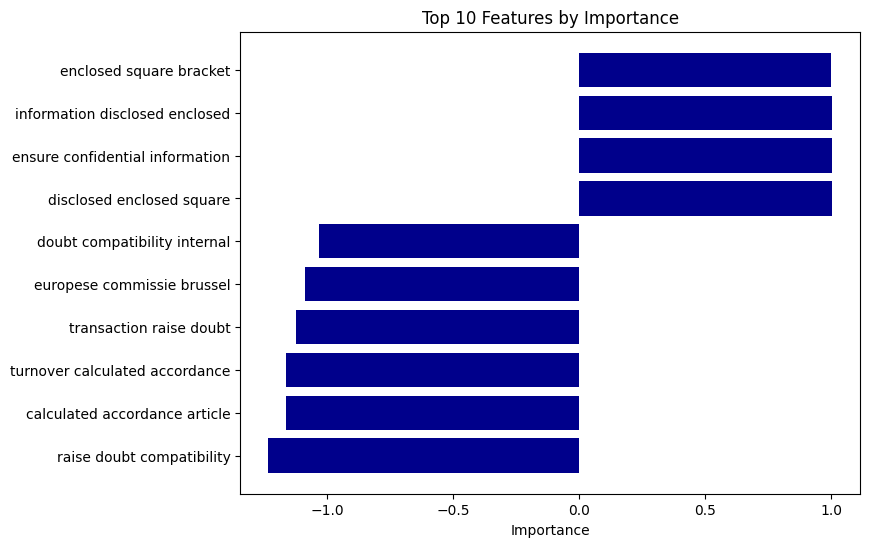

In [170]:
df_features_train['abs_importance'] = abs(df_features_train['importance'])
df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features by Importance')

plt.show()


Get features for label = 1 and label = 0

In [171]:
df_features_train1, df_features_train0 = get_feature_importance10(feature_importance, feature_names, y_train)

In [172]:
df_features_train1.head()

,feature,importance
20,accordance article merger,-0.883143
37,achieve aggregate community,-0.561689
65,affected market market,-0.518540
74,aggregate union wide,0.416102
56,adopted decision article,0.369754


In [173]:
df_features_train0.head()

,feature,importance
72,aggregate eu wide,-0.835360
39,achieve aggregate eu,-0.645714
71,aggregate community wide,-0.447899
77,agreement article decision,0.369754
45,acquire sole control,-0.368306


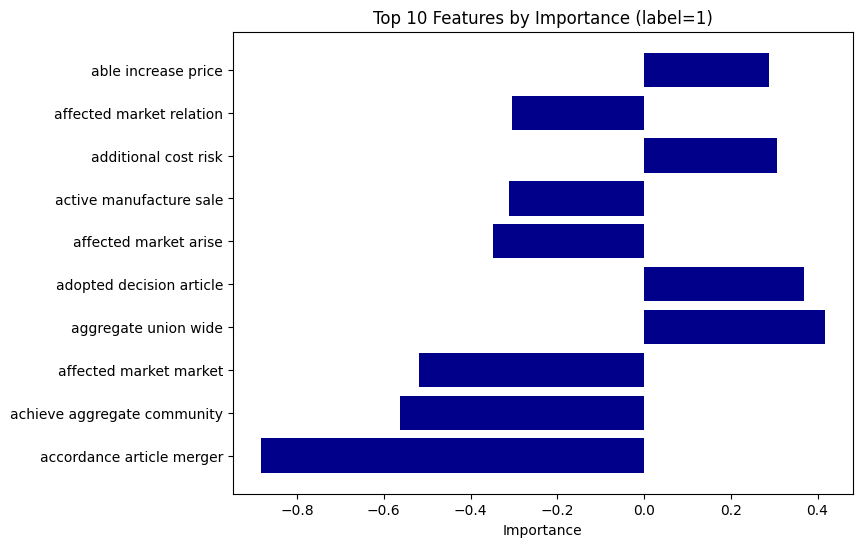

In [174]:
df_features_train1['abs_importance'] = abs(df_features_train1['importance'])
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(10, 'abs_importance') #importance

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='darkblue')
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features by Importance (label=1)')

plt.show()


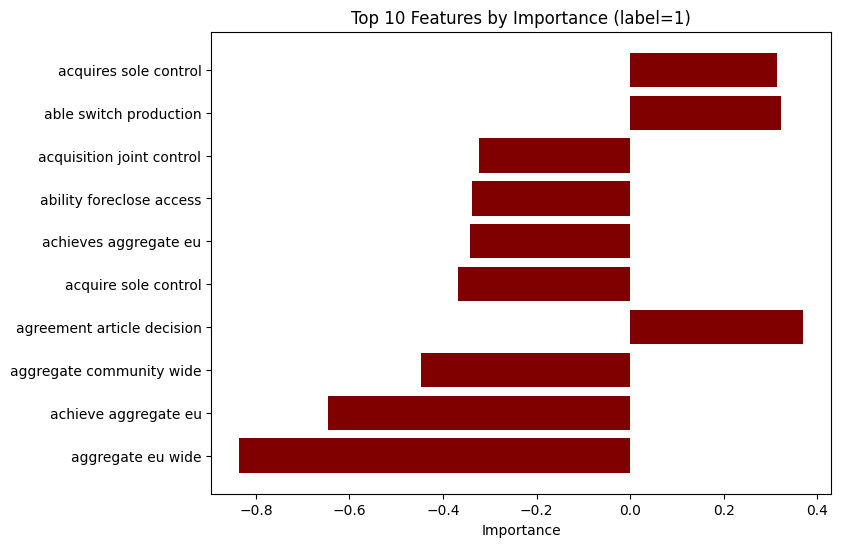

In [175]:
df_features_train0['abs_importance'] = abs(df_features_train0['importance'])
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(10, 'abs_importance') #importance

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='maroon')
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features by Importance (label=1)')

plt.show()

In [176]:
df_features_train.to_excel('../../../output/features_logit_train_full.xlsx', index=True)
df_features_train1.to_excel('../../../output/features_logit_train1_full.xlsx', index=True)
df_features_train0.to_excel('../../../output/features_logit_train0_full.xlsx', index=True)